#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

## Predicting firm exit

In [2]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [3]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

# Set the location of your data directory
data_dir = base_dir + "da_data_repo"

# location folders
data_in = os.path.join(data_dir, "bisnode-firms/clean/")
data_out = os.path.join(data_dir, "bisnode-firms/")
output = os.path.join(data_out, "output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")
sys.path.append(func)



## Import data

In [4]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data = pd.read_csv("/workspaces/codespaces-jupyter/data/bisnode_firms_clean.csv")

In [5]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,19036.0,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,...,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,1.903600e+04,19036.000000,19036.000000,19036.000000,19036.000000
mean,2012.0,1.529275e+11,9.274374e+03,9.914862e+04,8.567028e+04,418.017165,1.641894e+03,1.220200e+03,1.451590e+05,5.869079e+03,...,0.004150,0.145619,0.267388,0.627548,0.135900,1.225573e+01,0.038926,0.021538,-0.048296,0.287703
std,0.0,1.377319e+11,4.975021e+04,4.377075e+05,4.202974e+05,7141.930068,3.283540e+04,3.212567e+04,1.105861e+06,1.305634e+05,...,0.064289,0.352733,0.442608,1.473032,0.342692,1.042676e+01,0.193424,0.145174,0.534214,0.602235
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.000000,0.083333,0.000000,2.074996e-07,0.000000,0.000000,-1.500000,0.000000
25%,2012.0,2.868348e+10,1.185185e+02,3.314815e+03,3.822222e+03,0.000000,0.000000e+00,0.000000e+00,1.074074e+02,-6.519444e+03,...,0.000000,0.000000,0.000000,0.125000,0.000000,4.049695e+00,0.000000,0.000000,-0.194249,0.000654
50%,2012.0,1.142688e+11,8.814815e+02,1.146852e+04,1.485185e+04,0.000000,0.000000e+00,0.000000e+00,4.600000e+03,2.407407e+02,...,0.000000,0.000000,0.000000,0.291667,0.000000,9.767982e+00,0.000000,0.000000,0.000000,0.025531
75%,2012.0,2.556061e+11,4.070370e+03,4.023333e+04,4.803796e+04,0.000000,0.000000e+00,0.000000e+00,3.940926e+04,4.066667e+03,...,0.000000,0.000000,1.000000,0.621691,0.000000,1.754330e+01,0.000000,0.000000,0.130772,0.188141
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,1.000000,42.118057,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [6]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


In [7]:
import seaborn as sns

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label="ROC Curve")
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")
    plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random Guess")
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    plt.figure(figsize=(8, 6))
    sns.lineplot(x="thresholds", y="loss", data=all_coords_copy, color="blue")
    plt.axvline(x=optimal_threshold, color="red", linestyle="--", label="Optimal Threshold")
    plt.text(
        optimal_threshold - 0.01,
        max(all_coords_copy["loss"]) - 0.4,
        f"Best Threshold: {round(optimal_threshold, 2)}",
        rotation=90,
        color="red",
    )
    plt.text(optimal_threshold + 0.06, curr_exp_loss, f"{round(curr_exp_loss, 2)}", color="black")
    plt.xlabel("Thresholds")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.legend()
    plt.grid(True)
    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plt.figure(figsize=(8, 6))
    sns.lineplot(x="sp", y="se", data=all_coords_copy, color="blue", label="ROC Curve")
    plt.scatter([sp], [se], color="red", label=f"Optimal Point ({round(sp, 2)}, {round(se, 2)})")
    plt.fill_between(all_coords_copy["sp"], all_coords_copy["se"], alpha=0.3, color="mediumaquamarine")
    plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random Guess")
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("ROC Curve with Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()


## Model building

### Define variable sets 

 Main firm variables

In [8]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [9]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [10]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables

In [11]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

Human capital related variables

In [12]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [13]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [14]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

## Model setups

1. Simple logit models

In [15]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [16]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [17]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## 0. Separate train and holdout data

In [28]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [29]:
print("Total")
print(data["default"].value_counts(normalize=True))
print("Train")
print(data_train["default"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["default"].value_counts(normalize=True))


Total
default
0    0.797857
1    0.202143
Name: proportion, dtype: float64
Train
default
0    0.799186
1    0.200814
Name: proportion, dtype: float64
Holdout
default
0    0.792542
1    0.207458
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [30]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [31]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [32]:
C_value_logit = [1e20]

In [34]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

### b) Logit + LASSO

In [35]:
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [ ]:
# we skip it here - do the logit+lasso w/o normalization

#normalized_logitvars = pd.DataFrame(
#    StandardScaler().fit_transform(X_train),
#    columns=X_train.design_info.column_names,
#)

Set regularization parameters

In [ ]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = X_train.shape[0] * 4 / 5  # same logic
# n_obs = normalized_logitvars.shape[0] * 4 / 5 - old
#C_values = [1 / (l * n_obs) for l in lambdas]  # Cs are the inverse of regularization strength // old, but apperently the same formula yes
C_values_no_std = [1 / (l * n_obs) for l in lambdas]

In [40]:
lambdas

[np.float64(0.1),
 np.float64(0.046415888336127795),
 np.float64(0.021544346900318846),
 np.float64(0.010000000000000005),
 np.float64(0.004641588833612782),
 np.float64(0.002154434690031887),
 np.float64(0.001000000000000001),
 np.float64(0.0004641588833612782),
 np.float64(0.00021544346900318867),
 np.float64(0.00010000000000000021)]

In [39]:
C_values_no_std

[np.float64(0.000820856317310218),
 np.float64(0.0017684813255449529),
 np.float64(0.0038100775164276145),
 np.float64(0.008208563173102175),
 np.float64(0.01768481325544952),
 np.float64(0.0381007751642761),
 np.float64(0.08208563173102171),
 np.float64(0.1768481325544952),
 np.float64(0.3810077516427611),
 np.float64(0.8208563173102164)]

Initialize and fit Logit Lasso

In [42]:
logLasso_brier_no_std = LogisticRegressionCV(
    Cs=C_values_no_std,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO_no_std"] = logLasso_brier_no_std.fit(X_train, y_train)

See CV-fold RMSE-s (negative brier score)

In [46]:
cv_summary_lasso = cv_summary(lambdas, C_values_no_std, logit_models["LASSO_no_std"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

#without normalization

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.380698
1,0.046416,0.001768,0.377827
2,0.021544,0.003810,0.373519
3,0.010000,0.008209,0.368393
4,0.004642,0.017685,0.364579
5,0.002154,0.038101,0.363081
6,0.001000,0.082086,0.362112
7,0.000464,0.176848,0.361609
8,0.000215,0.381008,0.362004
9,0.000100,0.820856,0.361822


Save best lambda's index for later use

In [45]:
cv_summary_lasso["mean_cv_score"].idxmin()

7

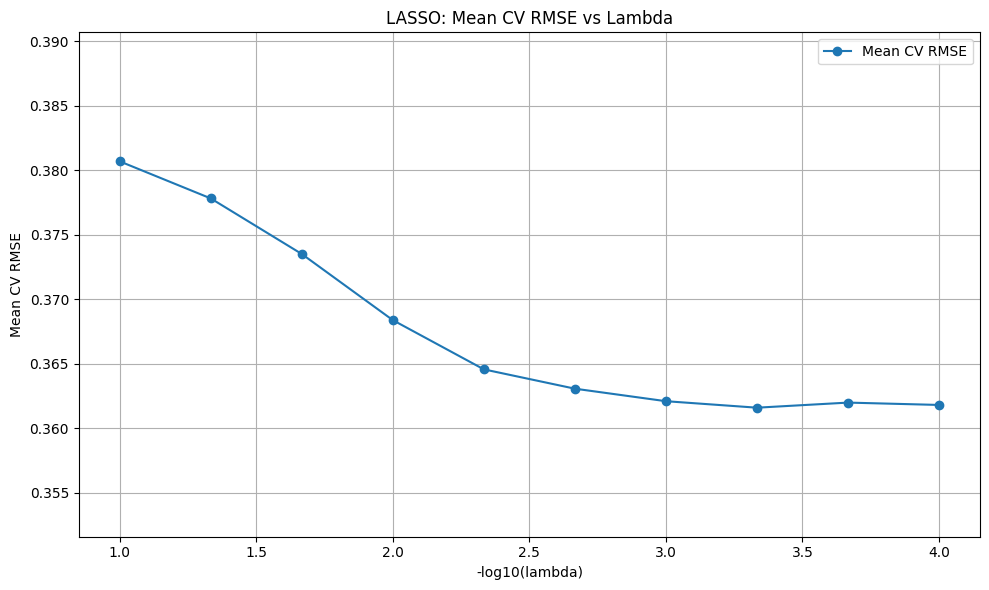

In [47]:
# Plot lambdas vs mean CV RMSE with zoomed-in Y-axis
plt.figure(figsize=(10, 6))
plt.plot(-np.log10(lambdas), cv_summary_lasso["mean_cv_score"], marker='o', label="Mean CV RMSE")
plt.xlabel("-log10(lambda)")
plt.ylabel("Mean CV RMSE")
plt.title("LASSO: Mean CV RMSE vs Lambda")
plt.ylim(cv_summary_lasso["mean_cv_score"].min() - 0.01, cv_summary_lasso["mean_cv_score"].max() + 0.01)  # Adjust Y-axis limits
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [1]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.375
RMSE: 0.6123724356957945
